In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  False
cpu


# Data Import

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_DataSet.hdf5"
path_density = "./data/NKAS_density.hdf5"

f = h5py.File(path_data, 'r')
# Entropy dataset
X_entropy_train = f["X_entropy_train"].value
y_entropy_train = f["y_entropy_train"].value

X_entropy_valid = f["X_entropy_valid"].value
y_entropy_valid = f["y_entropy_valid"].value

X_entropy_test = f["X_entropy_test"].value
y_entropy_test = f["y_entropy_test"].value

# Viscosity dataset
X_train = f["X_train"].value
y_train = f["y_train"].value

X_valid = f["X_valid"].value
y_valid = f["y_valid"].value

X_test = f["X_test"].value
y_test = f["y_test"].value

# Tg dataset
X_tg_train = f["X_tg_train"].value
X_tg_valid= f["X_tg_valid"].value
X_tg_test = f["X_tg_test"].value

y_tg_train = f["y_tg_train"].value
y_tg_valid = f["y_tg_valid"].value
y_tg_test = f["y_tg_test"].value

f.close()

# Raman dataset
f = h5py.File(path_raman, 'r')
X_raman_train = f["X_raman_train"].value
y_raman_train = f["y_raman_train"].value
X_raman_valid = f["X_raman_test"].value
y_raman_valid = f["y_raman_test"].value
f.close()

# Density dataset
f = h5py.File(path_density, 'r')
X_density_train = f["X_density_train"].value
X_density_valid = f["X_density_valid"].value
X_density_test = f["X_density_test"].value

y_density_train = f["y_density_train"].value
y_density_valid = f["y_density_valid"].value
y_density_test = f["y_density_test"].value
f.close()

# grabbing number of Raman channels
nb_channels_raman = y_raman_valid.shape[1]

# preparing data

# viscosity
x_visco_train = torch.FloatTensor(X_train[:,0:4]).to(device)
T_visco_train = torch.FloatTensor(X_train[:,4].reshape(-1,1)).to(device)
y_visco_train = torch.FloatTensor(y_train[:,0].reshape(-1,1)).to(device)

x_visco_valid = torch.FloatTensor(X_valid[:,0:4]).to(device)
T_visco_valid = torch.FloatTensor(X_valid[:,4].reshape(-1,1)).to(device)
y_visco_valid = torch.FloatTensor(y_valid[:,0].reshape(-1,1)).to(device)

x_visco_test = torch.FloatTensor(X_test[:,0:4]).to(device)
T_visco_test = torch.FloatTensor(X_test[:,4].reshape(-1,1)).to(device)
y_visco_test = torch.FloatTensor(y_test[:,0].reshape(-1,1)).to(device)

# entropy
x_entro_train = torch.FloatTensor(X_entropy_train[:,0:4]).to(device)
y_entro_train = torch.FloatTensor(y_entropy_train[:,0].reshape(-1,1)).to(device)

x_entro_valid = torch.FloatTensor(X_entropy_valid[:,0:4]).to(device)
y_entro_valid = torch.FloatTensor(y_entropy_valid[:,0].reshape(-1,1)).to(device)

x_entro_test = torch.FloatTensor(X_entropy_test[:,0:4]).to(device)
y_entro_test = torch.FloatTensor(y_entropy_test[:,0].reshape(-1,1)).to(device)

# tg
x_tg_train = torch.FloatTensor(X_tg_train[:,0:4]).to(device)
y_tg_train = torch.FloatTensor(y_tg_train.reshape(-1,1)).to(device)

x_tg_valid = torch.FloatTensor(X_tg_valid[:,0:4]).to(device)
y_tg_valid = torch.FloatTensor(y_tg_valid.reshape(-1,1)).to(device)

x_tg_test = torch.FloatTensor(X_tg_test[:,0:4]).to(device)
y_tg_test = torch.FloatTensor(y_tg_test.reshape(-1,1)).to(device)

# Density
x_density_train = torch.FloatTensor(X_density_train[:,0:4]).to(device)
y_density_train = torch.FloatTensor(y_density_train.reshape(-1,1)).to(device)

x_density_valid = torch.FloatTensor(X_density_valid[:,0:4]).to(device)
y_density_valid = torch.FloatTensor(y_density_valid.reshape(-1,1)).to(device)

x_density_test = torch.FloatTensor(X_density_test[:,0:4]).to(device)
y_density_test = torch.FloatTensor(y_density_test.reshape(-1,1)).to(device)

# Raman
x_raman_train = torch.FloatTensor(X_raman_train[:,0:4]).to(device)
y_raman_train = torch.FloatTensor(y_raman_train).to(device)

x_raman_valid = torch.FloatTensor(X_raman_valid[:,0:4]).to(device)
y_raman_valid = torch.FloatTensor(y_raman_valid).to(device)


# Multitask learning effect

In [19]:
# List of networks
list_models = os.listdir("./model/exp_multitask/")

result_multitask = pd.DataFrame()
result_multitask["mean"] = np.ones(5)
result_multitask["std"] = np.ones(5)
result_multitask["name"] = ["loss_ag","loss_ag_myega","loss_ag_myega_am","loss_ag_myega_am_ram","loss_ag_myega_am_ram_d"]

# Loss criterion
criterion = torch.nn.MSELoss()

# Loop for changing the losses
for j in range(len(result_multitask.loc[:,"name"])):
    
    loss_ag_test = np.ones(10) # the array to store values for the 10 networks
    for i in range(10): # start to loop over the 10 networks generated to get some statistics
        
        name = result_multitask.loc[j,"name"]+"_"+str(i)
        
        # Declare model
        neuralmodel = neuravi.model(4,300,3,nb_channels_raman,p_drop=0.3) 
        neuralmodel.load_state_dict(torch.load("./model/exp_multitask/"+name, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
        y_ag_pred_test = neuralmodel.ag(x_visco_test,T_visco_test) # test
        
        # Compute Loss 
        loss_ag_test[i] = criterion(y_ag_pred_test, y_visco_test).item() # test
    
    # record result in the Pandas result dataframe
    result_multitask.loc[j,"mean"] = loss_ag_test.mean()
    result_multitask.loc[j,"std"] = loss_ag_test.std()

Text(0, 0.5, 'mean MSE AG, test subset')

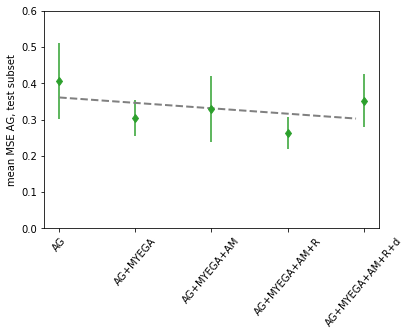

In [36]:
x_names = ["AG","AG+MYEGA","AG+MYEGA+AM","AG+MYEGA+AM+R","AG+MYEGA+AM+R+d"]

plt.errorbar(x_names,result_multitask["mean"],yerr=result_multitask["std"],fmt="d",color="C2")

plt.plot(np.arange(0,4,0.1), # X
         np.polyval(np.polyfit(np.arange(0,5,1),result_multitask["mean"],1),np.arange(0,4,0.1)), # Y
         "--",color="grey",linewidth=2
        )

plt.ylim(0,0.6)

plt.xticks(rotation=50)

plt.ylabel("mean MSE AG, test subset")